# Feature Preparation Notebook

This notebook curates annotations for traits and gene sets. These include:
* All the gene set annotations from *Notebook 1C*
* Network properties of the gene sets
* Heritability and prevalence estimates

**Inputs:**
* Supplemental Table 1 - Input Information (`STable1.tsv`)
* Supplemental Table 2 - NetColoc Results (`Stable2.tsv`)
* Biological properties of gene sets (`Features_bio_genesets.txt`)

* Network properties of gene sets (`Raw_network_features.txt`)

**Figures Generated:**
- SFig 2A - feature correlations

**Data generated:**
- Supplemental Table 3 - Heritability and Prevalance estimates
- Supplemental Table 4 - Gene set and trait features
* Trait and study features (`Raw_input_features.txt`)


## Set Up

In [159]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [160]:
cwd = os.getcwd()
datadir = os.path.join(cwd, '..')

In [161]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data', 'Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'

In [162]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

### Load COLOC data

In [163]:
def get_trait_pair(df):
    df['trait_pair'] = df['Rare Study'].astype(int).astype(str) + '_' + df['EFO'] +'_' +df['Common Study'] +'_'+ df['EFO']
    return df

In [164]:
coloc_df = pd.read_csv(os.path.join(datadir, 'outputs/STable2.tsv'), sep='\t')
coloc_df = get_trait_pair(coloc_df)
best_df = coloc_df[coloc_df['Optimal COLOC']].copy()

In [165]:
all_pairs = coloc_df.trait_pair.values

In [166]:
best_pairs = best_df.trait_pair.values

In [177]:
info_df = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t')

## Heritability  and Prevalence

### Heritability

In [178]:
ukb_df = pd.read_csv(os.path.join(datadir,'Reference_Data/ukb31063_h2_topline.02Oct2019.tsv.gz'), sep='\t')

In [179]:
# exclude pigmentation and bilirubin 
# (as per https://nealelab.github.io/UKBB_ldsc/confidence.html#unusually_large_standard_errors)
exclude = ['1717', '1727', '1747_1','1747_2','1747_3', '1747_4', '1747_5','1747_6', '30660_irnt', '30840_irnt']

In [180]:
ukb_df = ukb_df[(~ukb_df.phenotype.isin(exclude)) & (~ukb_df.isBadOrdinal)]

#### Trait matching

In [183]:
domain_info = info_df.loc[:, ['Mapped EFO', 'Trait Type', 'Biological Domain', 'Mapped Trait']].drop_duplicates()
domain_info.columns = ['EFO', 'trait_type', 'Domain', 'TRAIT']

In [184]:
ukb = model.encode(ukb_df.description.values, batch_size=32)
efo = model.encode(domain_info.TRAIT.values, batch_size=32)
cosines = cosine_similarity(ukb, efo)

In [185]:
results = []
for i in range(373):
    best = np.argmax(cosines[:, i])
    results.append((domain_info.TRAIT.values[i], ukb_df.description.values[best], cosines[best, i]))

Perform manual curation

In [186]:
pd.DataFrame(results, columns=['EFO', 'UKB', 'Cosine']).to_csv(os.path.join(datadir, 'outputs/heritability_data_match.tsv'), sep='\t')

In [187]:
matches = pd.read_csv(os.path.join(datadir, 'outputs/Heritability match - Sheet1.tsv'), sep='\t', index_col=0)

In [188]:
matches = matches[matches.Keep==1]
matched_EFO = domain_info[domain_info.TRAIT.isin(matches.EFO.values)]
matches = matches.rename(columns={'EFO':'TRAIT', 'UKB':'description'})

In [189]:
h_df = ukb_df[ukb_df.description.isin(matches.description.values)]
h_df = h_df.merge(matches, on='description', how='left')
h_df = h_df.merge(matched_EFO, on=[ 'TRAIT'], how='left')
# duplicate UKB traits
h_df = h_df[~h_df.phenotype.isin(['23104_irnt', '23098_irnt'])]

In [190]:
h_df.shape

(197, 43)

### Prevalence

In [191]:
gbd_df = pd.read_csv(os.path.join(datadir, 'Reference_Data/IHME-GBD_2021_DATA-Prevalence.csv'))
gbd_df = gbd_df.groupby(['measure_id', 'measure_name', 'location_id', 'location_name', 'sex_id',
       'sex_name', 'age_id', 'age_name', 'cause_id', 'cause_name', 'metric_id',
       'metric_name']).mean().reset_index()

#### Trait matching

In [192]:
gbd_ids = list(gbd_df.cause_name.unique())

gbd = model.encode(gbd_ids, batch_size=32)
cosines2 = cosine_similarity(gbd, efo)
results2 = []
for i in range(373):
    best = np.argmax(cosines2[:, i])
    results2.append((domain_info.TRAIT.values[i], gbd_ids[best], cosines2[best, i]))

In [193]:
pd.DataFrame(results2, columns=['EFO', 'GBD', 'Cosine']).to_csv(os.path.join(datadir, 'outputs/prevalence_data_match.tsv'), sep='\t')

In [194]:
prev_matches = pd.read_csv(os.path.join(datadir, 'outputs/Heritability match - Sheet2.tsv'), sep='\t', index_col=0)
prev_matches = prev_matches[prev_matches.Keep==1]

In [195]:
matched_EFO = domain_info[domain_info.TRAIT.isin(prev_matches.EFO.values)]
prev_matches = prev_matches.rename(columns={'EFO':'TRAIT', 'GBD':'cause_name'})
prev_df = gbd_df[gbd_df.cause_name.isin(prev_matches.cause_name.values)]
prev_df = prev_df.merge(prev_matches, on='cause_name', how='left')
prev_df = prev_df.merge(matched_EFO, on='TRAIT', how='left')

In [196]:
prev_df = prev_df[prev_df.metric_name=='Percent'].loc[:, ('EFO', 'val')].rename(columns={'val':'prevalence5year'})

In [197]:
prev_df.to_csv(os.path.join(datadir, 'outputs/Trait_prevalence.txt'), sep='\t', index=False)

In [198]:
prev_df.shape

(87, 2)

## Supplemental Table 3

In [199]:
h2_prev = h_df.loc[:, ['EFO', 'h2_observed', ]].merge(prev_df.loc[:, ['EFO','prevalence5year']], on='EFO', how='outer')

In [200]:
h2_prev.columns = ['EFO', 'SNP-Heritability', '5 Year Prevalence']

In [ ]:
h2_prev.to_csv(os.path.join(datadir, 'outputs/STable3.tsv'), sep='\t', index=False)

## Regression Features

In [201]:
coloc_df = pd.read_csv(os.path.join(datadir, 'outputs/STable2.tsv'), sep='\t')
coloc_df = get_trait_pair(coloc_df)
best_df = coloc_df[coloc_df['Optimal COLOC']].copy()
all_pairs = coloc_df.trait_pair.values

In [202]:
coloc_df = coloc_df.loc[:, ('EFO', 'Common Study', 'Rare Study','nCommon', 'nRare', 'nShared', 'Log2SizeOE', 'trait_pair')]
coloc_df['J_RC'] = coloc_df.nShared / (coloc_df.nRare+coloc_df.nCommon-coloc_df.nShared)
coloc_df['jaccard_zero'] = coloc_df.J_RC.apply(lambda z: 1 if z==0 else 0)
coloc_df = coloc_df.rename(columns={'nCommon':'g_C', 'nRare':'g_R'})
coloc_df['TraitR'] = coloc_df.trait_pair.apply(lambda x: '_'.join(x.split('_')[0:3]))
coloc_df['TraitC'] = coloc_df.trait_pair.apply(lambda x: '_'.join(x.split('_')[3:]))

### Study Info

In [203]:
study_info = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t')
study_info['StudyTrait'] = study_info['Study Identifier'].astype(str)+'_'+study_info['Mapped EFO']

In [204]:
binary_dict = {k: 1 if x=='Categorical' else 0 for k, x in study_info.set_index('Mapped EFO')['Trait Type'].to_dict().items()}
common_size = study_info[study_info['Variant Type']=='Common'].set_index('StudyTrait')['Population Sample Size'].to_dict()
rare_size = study_info[study_info['Variant Type']=='Rare'].set_index('StudyTrait')['Population Sample Size'].to_dict()

In [205]:
coloc_df['N_C'] = coloc_df.TraitC.map(common_size)
coloc_df['N_R'] = coloc_df.TraitR.map(rare_size)
coloc_df['binary'] = coloc_df.EFO.map(binary_dict)

In [206]:
coloc_df = coloc_df.set_index('trait_pair')

### Biological features

In [207]:
bio_df = study_info.set_index('StudyTrait').loc[:,[ 'sHet', 'Length', 'nGO', 'n_mrna', 'mrna', 'Variant Type'] ]

In [208]:
bio_df = bio_df.rename(columns={'sHet':'Constraint', 'Length':'GeneSize', 'nGO':'GO', 'Variant Type':'Set',
                               'n_mrna':'nTissues', 'mrna':'mRNA'})
bio_df.index.name=''

In [209]:
# decision = go with mean and DiffRC
def get_mean_diff_rc(bio_df,info_df, metrics=[ 'pli', 'Length', 'GO', 'mrna', 'n_mrna']):
    out_dict = {}
    for tR, tC, oe, j, nc, nr in tqdm(zip(info_df.TraitR.values, info_df.TraitC.values, info_df.Log2SizeOE.values, 
                                  info_df.J_RC.values, info_df.g_C.values, info_df.g_R.values)):
        out_dict[tR+'_'+tC] = {'log2SizeOE':oe, 'J':j}
        for metric in metrics:
            vals = bio_df.loc[[tR, tC], [metric, 'Set']].set_index('Set')[metric].to_dict()
            out_dict[tR+'_'+tC][f'Mean_{metric}'] =  (nc*vals['Common'] + nr*vals['Rare'])/(nc+nr)
            out_dict[tR+'_'+tC][f'DiffRC_{metric}'] = 2*(vals['Rare']- vals['Common'])/(vals['Rare']+vals['Common'])
                                  
    out_df = pd.DataFrame(out_dict).T
    return out_df

In [210]:
bio_feat = get_mean_diff_rc(bio_df, coloc_df, metrics= ['Constraint', 'GO', 'GeneSize', 'mRNA', 'nTissues'])

1634it [00:05, 302.18it/s]


### Network features

In [211]:
net_df = pd.read_csv(os.path.join(datadir, 'outputs/Raw_network_features.txt'), sep='\t', index_col=0)

In [212]:
use_net = net_df.loc[~net_df.varset.isin(['subnetwork', 'overlap']), ('trait_pair', 'subnetwork_density', 'assortativity', 'varset')]
use_net = use_net.pivot(index='trait_pair', columns='varset', values=['subnetwork_density', 'assortativity']).reset_index()
net_features = [['subnetwork_density', 'rare'], 'subnetwork_density-common', 'assortativity-rare_common']
net_feat = use_net.loc[:, [('trait_pair', ''), ('subnetwork_density', 'rare'), ('subnetwork_density', 'common'), ('assortativity', 'rare_common')]]
net_feat.columns=['trait_pair', 'subnetwork_density_rare', 'subnetwork_density_common', 'assortativity_rare_common']
net_feat = net_feat.set_index('trait_pair')

In [213]:
net_feat = net_feat.rename(columns={'subnetwork_density_rare':'density_R', 'subnetwork_density_common': 'density_C', 
                                    'assortativity_rare_common':'assortativity_RC'})

In [214]:
net_df = net_df.set_index('trait_pair')

### Supplemental Table 4

In [215]:
all_feat = coloc_df.join(bio_feat.drop(columns=['log2SizeOE', 'J'])).join(net_feat).drop(columns=['TraitC', 'TraitR'])

In [216]:
all_feat.to_csv(os.path.join(datadir, 'outputs/STable4.tsv'), sep='\t')

In [217]:
feature_names={
    'N_C': 'Study Size - Common',
    'N_R': "Study Size - Rare",
    'assortativity_RC':'Assortativity',
    'n_common': 'Number of Genes - Common',
    'n_rare': 'Number of Genes - Rare',
    'jaccard': 'Jaccard Sim.',
    'density_R': 'Subnetwork Density - Rare',
    'density_C': 'Subnetwork Density - Common',
    'binary': 'Is Trait Binary',
    'jaccard_zero': 'No shared genes', 
    'Mean_Constraint': 'Mean Constraint', 
    'DiffRC_Constraint':'Diff. Constraint', 
    'Mean_GeneSize':'Mean Gene Size', 
    'DiffRC_GeneSize':'Diff. Gene Size',
    'Mean_GO': 'Mean GO Terms', 
    'DiffRC_GO': 'Diff. GO Terms', 
    'Mean_mRNA': 'Mean Exp.', 
    'DiffRC_mRNA': 'Diff. Exp.', 
    'Mean_nTissues': 'Mean Exp. Tissues',
    'DiffRC_nTissues': 'Diff. Exp. Tissues'}

In [218]:
all_feat.columns

Index(['EFO', 'Common Study', 'Rare Study', 'g_C', 'g_R', 'nShared',
       'Log2SizeOE', 'J_RC', 'jaccard_zero', 'N_C', 'N_R', 'binary',
       'Mean_Constraint', 'DiffRC_Constraint', 'Mean_GO', 'DiffRC_GO',
       'Mean_GeneSize', 'DiffRC_GeneSize', 'Mean_mRNA', 'DiffRC_mRNA',
       'Mean_nTissues', 'DiffRC_nTissues', 'density_R', 'density_C',
       'assortativity_RC'],
      dtype='object')

In [219]:
plot_feat = all_feat.rename(columns=feature_names)

## SFig 2A - Feature Correlations

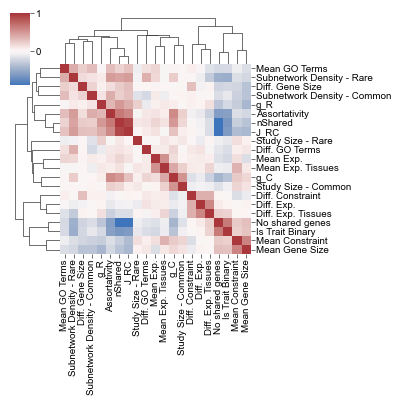

In [220]:
sns.clustermap(plot_feat.drop(columns=['EFO','Common Study', 'Rare Study', 'Log2SizeOE']).corr(method='spearman'), figsize=(4,4), cmap='vlag', center=0)